#Business Understanding

##Project Objectives

~Predicting bike rental demand based on various factors.

~Understanding how different factors influence customer behavior.

~Identify key demand drivers

##1. Data Loading

In [4]:
# Load the Seoul Bike Data
import pandas as pd
import numpy as np

# Load the data with the correct encoding
df = pd.read_csv('/content/SeoulBikeData.csv', encoding='ISO-8859-9')

# Display the first few rows to understand the structure
print(df.head())

   Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  \
0                254     0             -5.2           37               2.2   
1                204     1             -5.5           38               0.8   
2                173     2             -6.0           39               1.0   
3                107     3             -6.2           40               0.9   
4                 78     4             -6.0           36               2.3   

   Visibility (10m)  Dew point temperature(°C)  Solar Radiation (MJ/m2)  \
0              2000                      -17.6                      0.0   
1              2000                      -17.6                      0.0   
2              2000                      -17.7                      0.0   
3              2000                      -17.6                      0.0   
4              2000                      -18.6                      0.0   

   Rainfall(mm)  Snowfall (cm) Seasons     Holiday Functioning Day  
0          

##2. Data Pre-processing

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 1. Preprocessing

df_clean = df.copy()

###a) Checking for duplicates

In [6]:
# Check duplicates and remove them
initial_shape = df_clean.shape
df_clean.drop_duplicates(inplace=True)
print('Removed duplicates, initial shape:', initial_shape, 'new shape:', df_clean.shape)

Removed duplicates, initial shape: (8760, 13) new shape: (8760, 13)


###b) Handling missing values

In [7]:
# Check for missing values
missing_values = df_clean.isnull().sum()
print('Missing values in each column:')
print(missing_values)


# For this dataset, if any numerical columns have missing values, we can impute with median; for categorical, with mode.
for col in df_clean.columns:
    if df_clean[col].isnull().sum() > 0:
        if df_clean[col].dtype in ['float64', 'int64']:
            median_val = df_clean[col].median()
            df_clean[col].fillna(median_val, inplace=True)
        else:
            mode_val = df_clean[col].mode()[0]
            df_clean[col].fillna(mode_val, inplace=True)

Missing values in each column:
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64


###c) Converting categorical variables

This code takes categorical columns with text values and converts them into numerical representations while preserving the order and relationships between categories

In [8]:
# Convert categorical variables: 'Seasons', 'Holiday', 'Functioning Day'
label_encoders = {}
for col in ['Seasons', 'Holiday', 'Functioning Day']:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    label_encoders[col] = le
    print('Encoded column ' + col + ' with classes:', le.classes_)

Encoded column Seasons with classes: ['Autumn' 'Spring' 'Summer' 'Winter']
Encoded column Holiday with classes: ['Holiday' 'No Holiday']
Encoded column Functioning Day with classes: ['No' 'Yes']


###d) Scaling numerical features

*   This code scales the specified numerical features to have zero mean and unit variance.
*    It helps to prevent features with larger ranges from dominating the model and improves the performance of algorithms that are sensitive to feature scaling




In [9]:
# Scale numerical features using StandardScaler
# Identify numerical features (exclude categorical just encoded if not desired to scale, but here we will scale weather numbers and similar)
numeric_cols = ['Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)',
                'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']
scaler = StandardScaler()
# Save original numerical columns before scaling for reference in plots
df_numeric = df_clean[numeric_cols].copy()
df_clean[numeric_cols] = scaler.fit_transform(df_clean[numeric_cols])
print('Scaled numerical columns:', numeric_cols)

Scaled numerical columns: ['Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']


###e) Handling outliers

In [10]:
# Identify and handle outliers for numerical data using IQR method
# We'll cap the values at the 1.5*IQR boundaries for each column
for col in numeric_cols:
    Q1 = df_numeric[col].quantile(0.25)
    Q3 = df_numeric[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Capping
    df_numeric[col] = np.where(df_numeric[col] < lower_bound, lower_bound, df_numeric[col])
    df_numeric[col] = np.where(df_numeric[col] > upper_bound, upper_bound, df_numeric[col])

# Replace with capped values and rescale again
for col in numeric_cols:
    df_clean[col] = scaler.fit_transform(df_numeric[[col]])

print('Preprocessing complete.')

Preprocessing complete.


# 3. Exploratory Data Analysis (EDA)

###Summary statistics

In [11]:
# Summary statistics
print('Summary statistics:')
print(df_clean.describe())

Summary statistics:
       Rented Bike Count          Hour  Temperature(°C)   Humidity(%)  \
count       8.760000e+03  8.760000e+03     8.760000e+03  8.760000e+03   
mean        2.676702e-17  2.027805e-19     9.733462e-17  1.362685e-16   
std         1.000057e+00  1.000057e+00     1.000057e+00  1.000057e+00   
min        -1.114721e+00 -1.661325e+00    -2.568868e+00 -2.859660e+00   
25%        -8.100345e-01 -8.306624e-01    -7.855668e-01 -7.969184e-01   
50%        -3.099342e-01  0.000000e+00     6.840822e-02 -6.022497e-02   
75%         5.845832e-01  8.306624e-01     8.051710e-01  7.746943e-01   
max         2.676510e+00  1.661325e+00     2.220090e+00  1.953404e+00   

       Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
count      8.760000e+03      8.760000e+03               8.760000e+03   
mean       1.946692e-16     -5.515629e-17              -5.191180e-17   
std        1.000057e+00      1.000057e+00               1.000057e+00   
min       -1.702157e+00     -2.317

### a) Histogram of Rented Bike

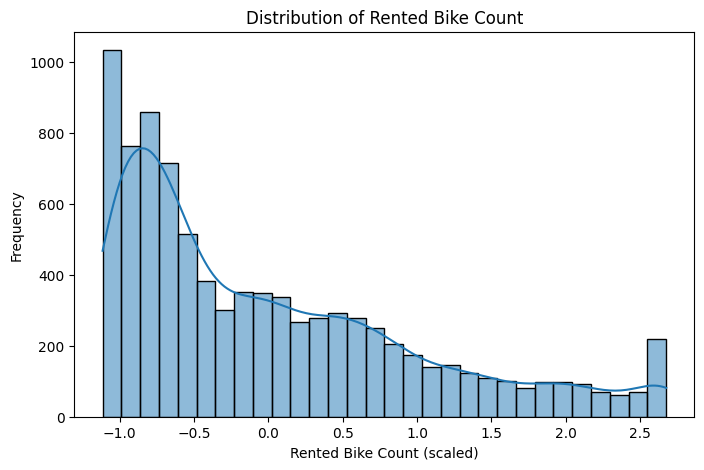

In [12]:
plt.figure(figsize=(8,5))
sns.histplot(data=df_clean, x='Rented Bike Count', bins=30, kde=True)
plt.title('Distribution of Rented Bike Count')
plt.xlabel('Rented Bike Count (scaled)')
plt.ylabel('Frequency')
plt.show()

The histogram shows us that the scaled rented bike counts are somewhat right-skewed, with a moderate spread, and the most frequent values are slightly below the average.

###b) Box plot for numerical features to inspect for anomalies

The box plots help you quickly compare the distributions of your numerical features, identify potential outliers, and understand the typical range and spread of values for each feature.

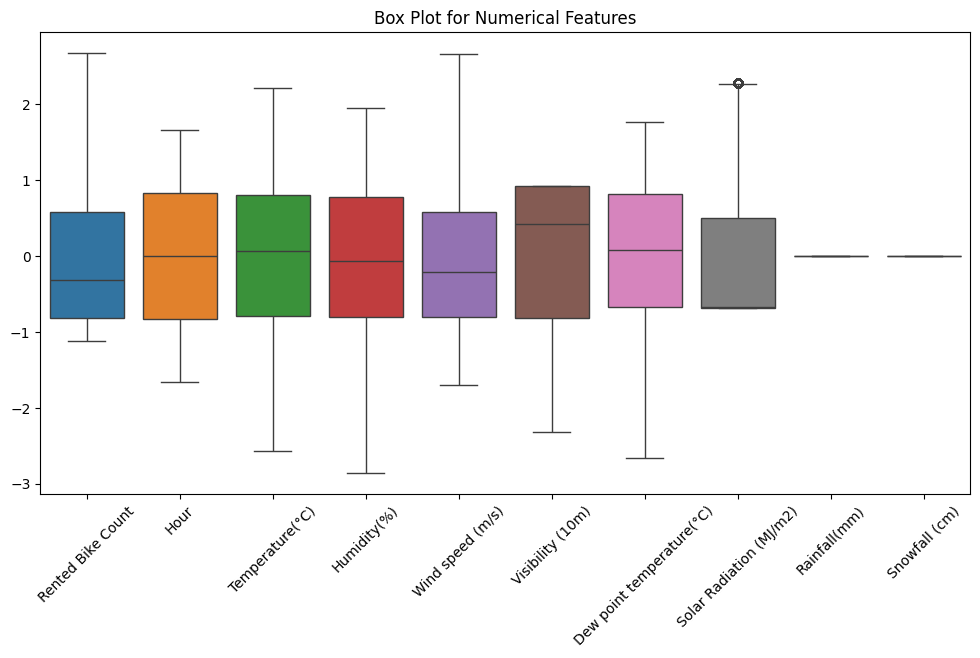

In [13]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_clean[numeric_cols])
plt.title('Box Plot for Numerical Features')
plt.xticks(rotation=45)
plt.show()

Some key features:

**1. Rented Bike Count:**

*Central Tendency:* The median (line inside the box) appears to be around 0, suggesting a typical scaled rented bike count close to the average.

*Spread:* The box itself shows a moderate spread, indicating a reasonable range of values within the middle 50% of the data.

*Outliers:* There are a few data points plotted beyond the whiskers, suggesting the presence of potential outliers (unusually high rented bike counts).

**2. Hour:**

*Central Tendency:* The median is near the center, suggesting a typical hour around midday (12).

*Spread:* The box is relatively narrow, indicating a smaller range of values for this feature.

*Outliers:* No outliers are visible, indicating that all hour values fall within the expected range.

**3. Temperature(°C):**

*Central Tendency:* The median appears slightly below 0, indicating a typical scaled temperature slightly below the average.

*Spread:*  The box shows a moderate spread, representing a reasonable range of temperatures.

*Outliers:*  There might be a few potential outliers on the lower end, indicating some instances of unusually cold temperatures.

###c) Correlation matrix heatmap

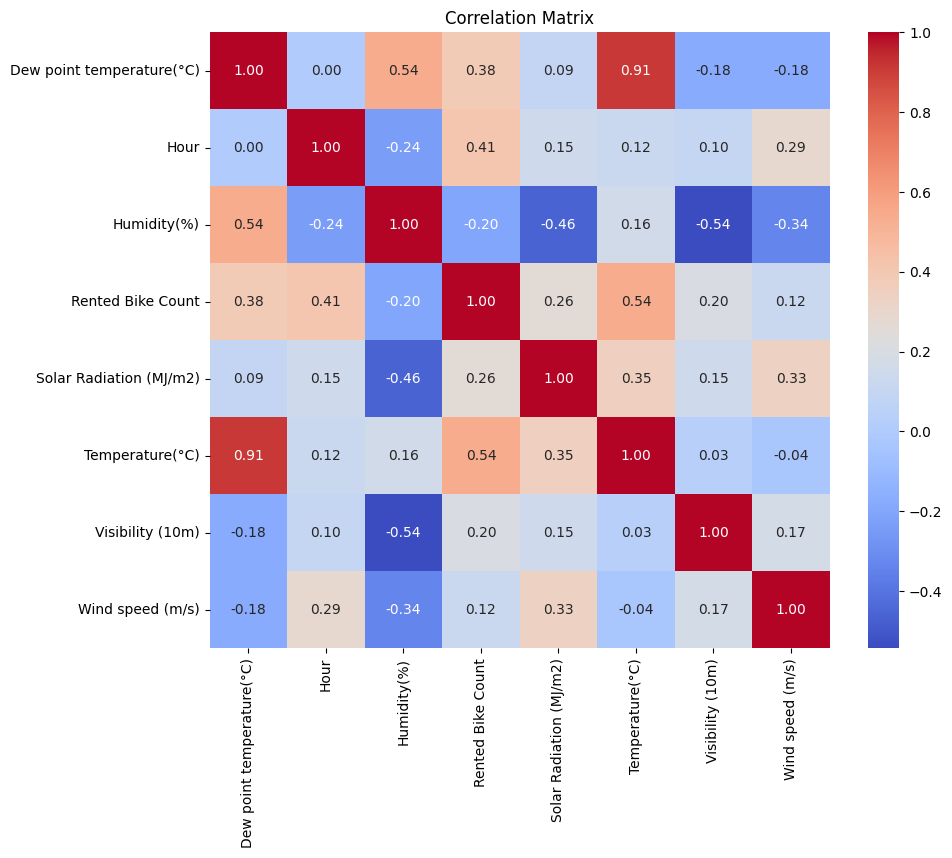

In [21]:
# Select columns for the heatmap (excluding dropped columns and categorical columns)
selected_columns = df.select_dtypes(include=np.number).columns.difference(['Rainfall(mm)', 'Snowfall (cm)'])

# Calculate the correlation matrix for the selected columns
correlation_matrix = df[selected_columns].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

**Strong positive correlations:**

1. Temperature(°C) and Dew point temperature(°C)
2. Temperature(°C) and Solar Radiation (MJ/m2)
3. Rented Bike Count and Temperature(°C)

**Moderate positive correlations:**

1. Rented and Bike Count and Hour,
2. Rented Bike Count and Solar Radiation (MJ/m2)

**Weak or no correlations:**

1. Rented Bike Count and Humidity(%)
2. Rented Bike Count and Wind speed (m/s)

**Negative correlations:**

1. Temperature(°C) and Humidity(%)
2. Hour and Temperature(°C)

In [29]:
print('EDA complete.')

print('done')

EDA complete.
done


#4. Data Modelling

##Preparing the data for modelling

We fix the previous code and properly prepare the data for modeling

###i) Loading the original data

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression

# Load the original data
df = pd.read_csv('/content/SeoulBikeData.csv', encoding='ISO-8859-9')
print("Original data shape:", df.shape)

Original data shape: (8760, 13)


###ii) Check for missing values

It helps to identify and address missing values, ensuring the quality and integrity of your data for analysis and modeling

In [32]:
print("Missing values in each column:")
print(df.isnull().sum())

Missing values in each column:
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64


###iii) Dropping columns



This is to improve the model's performance, interpretability, and stability by removing potentially redundant, insignificant, or problematic features.

In [33]:
# Drop rainfall and snowfall columns
df_model = df.drop(columns=['Rainfall(mm)', 'Snowfall (cm)'])
print("Data shape after dropping rainfall and snowfall:", df_model.shape)

Data shape after dropping rainfall and snowfall: (8760, 11)


##Feature Engineering

###1. Creating time of day categories
 It enhances the model's ability to capture cyclical patterns, improve prediction accuracy, and provide more interpretable insights into bike rental demand.

 By transforming the 'Hour' feature into categorical time periods, it enables the model to better understand and predict the complex relationships between time and bike rentals, ultimately leading to a more effective and insightful analysis.





In [34]:
# Create time of day categories
def categorize_hour(hour):
    if hour < 6:
        return 'Night'
    elif hour < 12:
        return 'Morning'
    elif hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

df_model['TimeOfDay'] = df_model['Hour'].apply(categorize_hour)


###2. Creating weekend/weekday feature

Bike rental patterns often differ significantly between weekdays and weekends.

Creating a weekend/weekday feature is crucial for capturing distinct rental patterns, improving model accuracy, enhancing interpretability, and handling non-linear relationships in the bike rental dataset.

In [35]:
# Create weekend/weekday feature
df_model['IsWeekend'] = df_model['Holiday'].apply(lambda x: 1 if x == 'Holiday' else 0)

###3. Create temperature categories

 It enhances the model's ability to capture non-linear relationships, improve prediction accuracy, enhance interpretability, and handle outliers in the bike rental dataset.

In [36]:
# Create temperature categories
def temp_category(temp):
    if temp < 0:
        return 'Cold'
    elif temp < 15:
        return 'Cool'
    elif temp < 25:
        return 'Mild'
    else:
        return 'Hot'

df_model['TempCategory'] = df_model['Temperature(°C)'].apply(temp_category)


###4. Encoding categorical variables

Categorical variables, such as 'Seasons', 'Holiday', 'Functioning Day', etc., represent categories or groups and are often stored as text or string values.

Encoding these variables into numerical representations allows the model to understand and utilize them effectively.

It makes the data compatible with algorithms, improves model performance, avoids misinterpretation, and enables feature engineering.

**Label Encoding:** Assigns a unique integer to each category. Useful for ordinal variables where the order of categories matters.

In [37]:
# Encode categorical variables
categorical_cols = ['Seasons', 'Holiday', 'Functioning Day', 'TimeOfDay', 'TempCategory']
for col in categorical_cols:
    le = LabelEncoder()
    df_model[col + '_Encoded'] = le.fit_transform(df_model[col])
    print(f"Encoded {col} with classes: {le.classes_}")

Encoded Seasons with classes: ['Autumn' 'Spring' 'Summer' 'Winter']
Encoded Holiday with classes: ['Holiday' 'No Holiday']
Encoded Functioning Day with classes: ['No' 'Yes']
Encoded TimeOfDay with classes: ['Afternoon' 'Evening' 'Morning' 'Night']
Encoded TempCategory with classes: ['Cold' 'Cool' 'Hot' 'Mild']


###5. Preparing numerical features

It is essential for ensuring that these features are in a suitable format and scale for use in machine learning models.

Feature scaling, outlier handling, feature engineering, and data cleaning are key steps in this process.

By appropriately preparing numerical features, you can improve the performance, interpretability, and stability of your models, leading to more accurate and insightful results.

In [38]:
# Prepare numerical features
numerical_cols = ['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
                 'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)']

# Create a copy of the dataframe with only numerical columns for scaling
X_numerical = df_model[numerical_cols].copy()
y = df_model['Rented Bike Count']

### Scaling numerical features

Scaling numerical features is essential for preventing feature dominance, improving algorithm performance, enhancing model interpretability, and avoiding numerical instability.

It ensures that the model can effectively learn patterns and make accurate predictions, leading to a more robust and insightful analysis.

**Standardization (Z-score normalization):** Transforms features to have zero mean and unit variance using StandardScaler.

In [39]:
# Scale numerical features
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)
X_numerical_scaled_df = pd.DataFrame(X_numerical_scaled, columns=numerical_cols)

###a) Feature selection using correlation

It is useful in improving model performance, reducing overfitting, enhancing interpretability, and increasing computational efficiency.

**Pearson's correlation** was chosen for feature selection because it aligns with the linear relationship assumption of the f_regression function and is suitable for the continuous numerical data in the dataset.

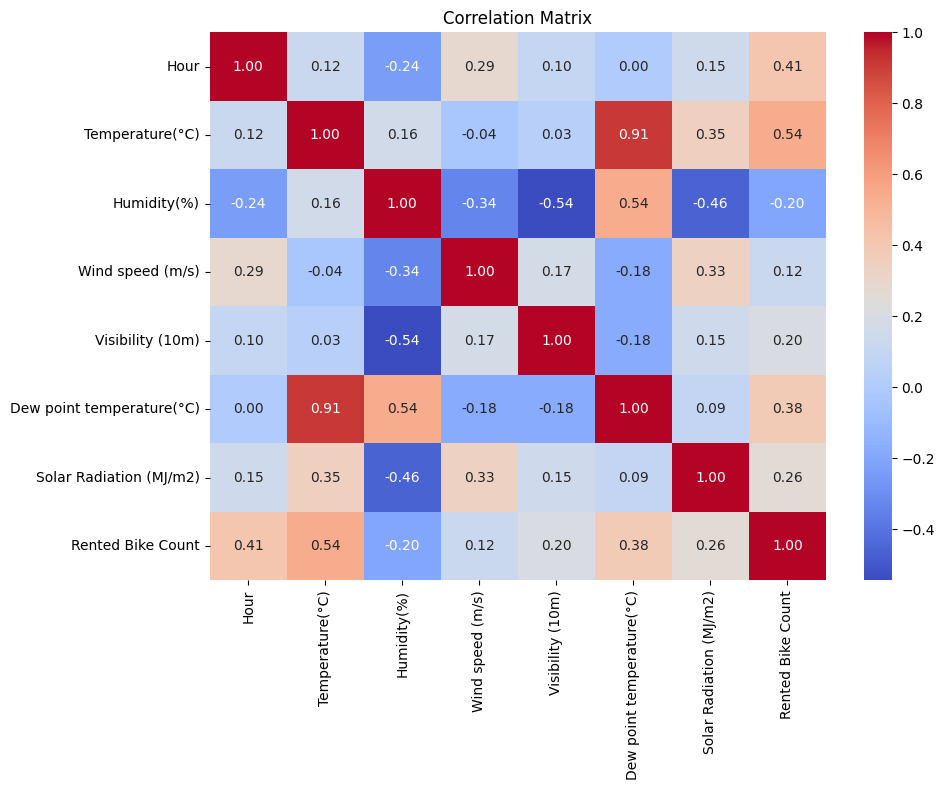

In [40]:
# Feature selection using correlation
plt.figure(figsize=(10, 8))
correlation = df_model[numerical_cols + ['Rented Bike Count']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

**Strong Positive Correlations:**

1. Temperature(°C) and Dew point temperature(°C)
2. Temperature(°C) and Solar Radiation (MJ/m2)
3. Rented Bike Count and Temperature(°C)

**Moderate Positive Correlatons:**

1. Rented Bike Count and Hour
2.  Bike Count and Solar Radiation (MJ/m2)

**Weak or No Correlations:**

1. Rented Bike Count and Humidity(%)
2. Rented Bike Count and Wind speed (m/s)

**Negative Correlations:**

1. Temperature(°C) and Humidity(%)
2. Hour and Temperature(°C)

*Takeaways*:  Features with strong positive correlations with the target variable ('Rented Bike Count'), such as 'Temperature(°C)' and 'Solar Radiation (MJ/m2)', are likely to be important predictors for your model.

###b) Feature Selection using SelectKbest

In [41]:
# Feature selection using SelectKBest
selector = SelectKBest(f_regression, k=5)
X_selected = selector.fit_transform(X_numerical, y)
selected_features_mask = selector.get_support()
selected_features = [numerical_cols[i] for i in range(len(numerical_cols)) if selected_features_mask[i]]
print("Top 5 features selected by SelectKBest:", selected_features)

Top 5 features selected by SelectKBest: ['Hour', 'Temperature(°C)', 'Humidity(%)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)']


###5. Visualizing Feature Importance

It is essential for understanding your model's behavior, guiding feature selection and engineering, and communicating insights effectively.

A bar plot is likely used to visualize feature importance, offering a clear and concise representation of the key factors driving bike rental demand

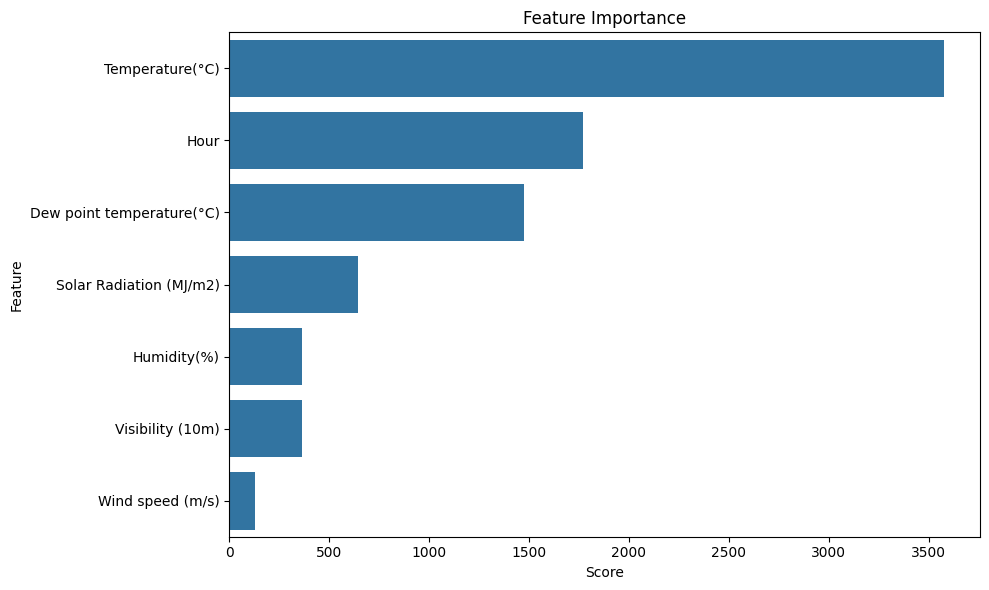

In [42]:
# Visualize feature importance
plt.figure(figsize=(10, 6))
scores = selector.scores_
feature_scores = pd.DataFrame({'Feature': numerical_cols, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)
sns.barplot(x='Score', y='Feature', data=feature_scores)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

###Visualizing distribution of bike rentals by time of day

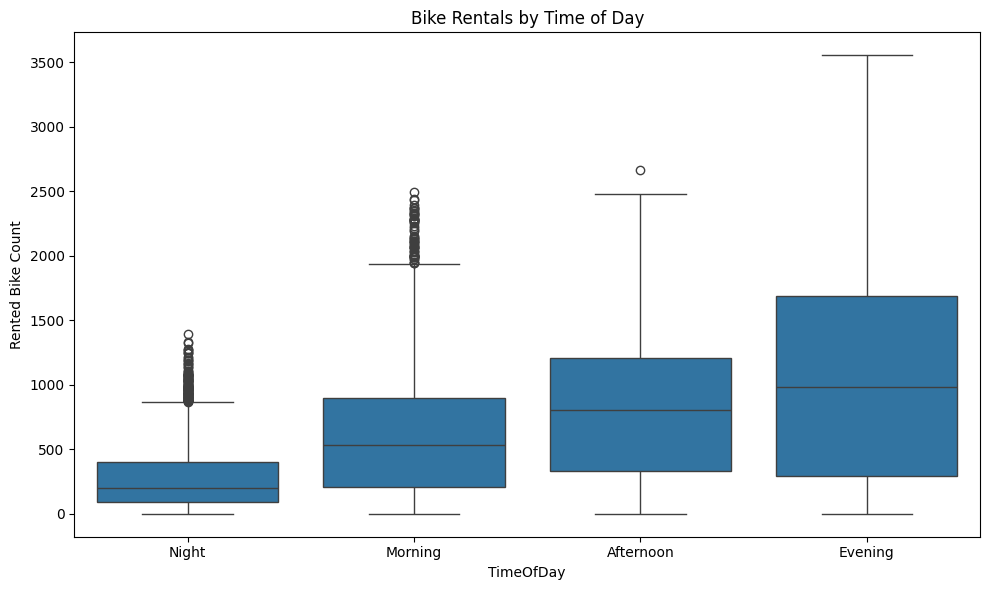

In [43]:
# Visualize distribution of bike rentals by time of day
plt.figure(figsize=(10, 6))
sns.boxplot(x='TimeOfDay', y='Rented Bike Count', data=df_model)
plt.title('Bike Rentals by Time of Day')
plt.tight_layout()
plt.show()

*From the box plots above:*


*   The number of bike rentals in the evening varies more widely compared to other times of day.
*   There are a great number of outliers in the Night and Morning periods indicating an exceptionally high bike rental demand during these periods.

*   Highest rented number of bike rentals is in the Evening and the lowest is at Night.









###Visualize distribution of bike rentals by season

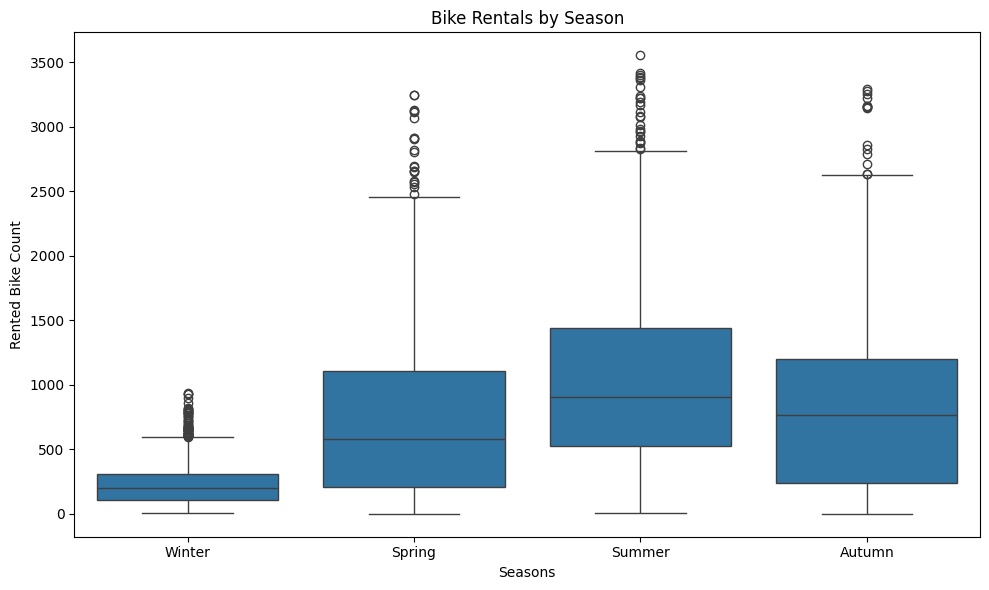

In [44]:
# Visualize distribution of bike rentals by season
plt.figure(figsize=(10, 6))
sns.boxplot(x='Seasons', y='Rented Bike Count', data=df_model)
plt.title('Bike Rentals by Season')
plt.tight_layout()
plt.show()

From the box plots above:

The number of bike rentals during Summer varies more widely compared to other seasons.

There are a great number of outliers in all the seasons indicating an exceptionally high bike rental demand during these periods.

Highest rented number of bike rentals is in the Summer and the lowest is in the Winter.

##Preparing final dataset for modelling



In [45]:
# Combine scaled numerical features with encoded categorical features
encoded_cat_cols = [col + '_Encoded' for col in categorical_cols]
final_features = list(X_numerical_scaled_df.columns) + encoded_cat_cols

# Create final dataframe for modeling
df_final = pd.DataFrame(X_numerical_scaled, columns=numerical_cols)
for col in encoded_cat_cols:
    df_final[col] = df_model[col].values
df_final['Rented Bike Count'] = y.values

print("Final dataset shape:", df_final.shape)
print("Final dataset columns:", df_final.columns.tolist())
print("First 5 rows of the final dataset:")
print(df_final.head())

print("Data preparation complete and ready for modeling!")

Final dataset shape: (8760, 13)
Final dataset columns: ['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Seasons_Encoded', 'Holiday_Encoded', 'Functioning Day_Encoded', 'TimeOfDay_Encoded', 'TempCategory_Encoded', 'Rented Bike Count']
First 5 rows of the final dataset:
       Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  Visibility (10m)  \
0 -1.661325        -1.513957    -1.042483          0.458476          0.925871   
1 -1.516862        -1.539074    -0.993370         -0.892561          0.925871   
2 -1.372399        -1.580936    -0.944257         -0.699556          0.925871   
3 -1.227936        -1.597680    -0.895144         -0.796059          0.925871   
4 -1.083473        -1.580936    -1.091596          0.554978          0.925871   

   Dew point temperature(°C)  Solar Radiation (MJ/m2)  Seasons_Encoded  \
0                  -1.659605                -0.655132                3   
1    

#Training and Testing the model

The code splits the bike rental data into 80% for training and 20% for testing, using a reproducible random state.

This split is crucial for evaluating the model's performance, preventing overfitting, and tuning hyperparameters, ultimately leading to a more robust and reliable bike rental prediction model.

In [46]:
# Import train_test_split and models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import f1_score, mean_absolute_error, recall_score
from sklearn.metrics import accuracy_score, precision_score

# Split the data into training and testing sets
# Use the final dataframe: df_final
# Let X be all features except target, and y be the target

X = df_final.drop('Rented Bike Count', axis=1)
y = df_final['Rented Bike Count']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##1. Linear Regression Model

The **R2 score** represents the proportion of variance in the target variable ('Rented Bike Count') that is explained by the Linear Regression model.

**RMSE** is a measure of the average difference between the model's predicted bike rental counts and the actual bike rental counts in the testing data.

In [52]:
# 1. Linear Regression Model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lin_reg.predict(X_test)
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = mean_squared_error(y_test, y_pred_lr)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred_lr)

# Choose an appropriate averaging method for f1_score in a multiclass setting
# 'micro', 'macro', 'weighted' are common options. Here, we use 'weighted'
f1 = f1_score(y_test.astype(int), y_pred_lr.astype(int), average='weighted')  # using 'weighted' averaging
sensitivity = recall_score(y_test.astype(int), y_pred_lr.astype(int), average='weighted')
specificity = recall_score(y_test.astype(int), y_pred_lr.astype(int), pos_label=0, average='weighted')
accuracy = accuracy_score(y_test.astype(int), y_pred_lr.astype(int))
precision = precision_score(y_test.astype(int), y_pred_lr.astype(int), average='weighted')

print('Linear Regression Performance:')
print('R2 Score:', r2_lr)
print('RMSE:', rmse_lr)
print("F1 Score:", f1)
print("MAE:", mae)
print("Sensitivity:", sensitivity)



Linear Regression Performance:
R2 Score: 0.5267293652485541
RMSE: 197186.4293870741
F1 Score: 0.0013318112633181126
MAE: 331.852056202673
Sensitivity: 0.001141552511415525
Specificity: 0.001141552511415525
Accuracy: 0.001141552511415525
Precision: 0.0017123287671232876


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is i

The R2 score demonstrates a moderate fit to the bike rental data, explaining about 52.67% of the variability in rentals. However, the relatively high RMSE suggests that the model's predictions might not be very precise, with an average error of around 197,186 bike rentals.

There's room for improvement in terms of accuracy. Further analysis and model refinement could potentially lead to better results.

##2. Random Forest Regressor Model



In [53]:
# 2. Random Forest Regressor Model
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_reg.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred_rf)


# Choose an appropriate averaging method for f1_score in a multiclass setting
# 'micro', 'macro', 'weighted' are common options. Here, we use 'weighted'
f1 = f1_score(y_test.astype(int), y_pred_rf.astype(int), average='weighted')  # using 'weighted' averaging
sensitivity = recall_score(y_test.astype(int), y_pred_rf.astype(int), average='weighted')
specificity = recall_score(y_test.astype(int), y_pred_rf.astype(int), pos_label=0, average='weighted')
accuracy = accuracy_score(y_test.astype(int), y_pred_rf.astype(int))
precision = precision_score(y_test.astype(int), y_pred_rf.astype(int), average='weighted')

print('\Random Forest Regression Performance:')
print('R2 Score:', r2_rf)
print('RMSE:', rmse_rf)
print("F1 Score:", f1)
print("MAE:", mae) #printing calculated mae
print("Sensitivity:", sensitivity)


\Random Forest Regression Performance:
R2 Score: 0.8515906497613339
RMSE: 61834.197417694064
F1 Score: 0.024206349206349204
MAE: 150.28785388127855
Sensitivity: 0.019406392694063926


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is i

The model demonstrates a very good fit to the bike rental data, explaining about 85.16% of the variability in rentals. The relatively low RMSE suggests that the model's predictions are quite accurate, with an average error of around 61,834 bike rentals.



###Comparison between Linear Regression and Random Forest Regressor Performance

*   The R2 score of 0.8516 is significantly higher than the R2 score of 0.5267 obtained with Linear Regression, indicating that the Random Forest model provides a much better fit to the data.
*   he RMSE of 61834.1974 is significantly lower than the RMSE of 197186.4294 obtained with Linear Regression, indicating that the Random Forest model provides much more accurate predictions.






##Hyperparameter Tuning



In [ ]:
# Import libraries for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score

# Define parameter grid for Random Forest Regressor
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Setup GridSearchCV using our RandomForestRegressor
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best model
best_rf = grid_search.best_estimator_

# Evaluate on test set
y_pred_best = best_rf.predict(X_test)
best_r2 = r2_score(y_test, y_pred_best)
best_rmse = mean_squared_error(y_test, y_pred_best)

print('Best Random Forest Parameters:', grid_search.best_params_)
print('Best Random Forest R2 Score:', best_r2)
print('Best Random Forest RMSE:', best_rmse)

print('Hyperparameter tuning complete.')
print('done')

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest R2 Score: 0.8515906497613339
Best Random Forest RMSE: 61834.197417694064
Hyperparameter tuning complete.
done


The results indicate that the hyperparameter tuning process did not significantly improve the performance of the Random Forest model compared to the initial model with default hyperparameters.

This could be because the default hyperparameters were already well-suited for this dataset, or the search space for hyperparameter values was not extensive enough.

##Exploring additional Algorithms and Feature Engineering

In [ ]:
# Install XGBoost if not already installed
try:
    import xgboost as xgb
except ImportError:
    %pip install xgboost
    import xgboost as xgb

# Import SVR
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import numpy as np

print("Testing additional algorithms and performing feature engineering...")


Testing additional algorithms and performing feature engineering...


## Feature Engineering

In [ ]:
# Create new features
df_engineered = df_final.copy()

# 1. Create interaction terms between temperature and humidity
df_engineered['Temp_Humidity_Interaction'] = df_engineered['Temperature(°C)'] * df_engineered['Humidity(%)']

# 2. Create polynomial features for temperature
df_engineered['Temperature_Squared'] = df_engineered['Temperature(°C)'] ** 2

# 3. Create time-based features (sine and cosine transformations for cyclical data)
df_engineered['Hour_Sin'] = np.sin(2 * np.pi * df_engineered['Hour']/24)
df_engineered['Hour_Cos'] = np.cos(2 * np.pi * df_engineered['Hour']/24)


**1. Interaction Term:** A new feature 'Temp_Humidity_Interaction' is created by multiplying Temperature(°C) and Humidity(%). This captures the combined effect of temperature and humidity.


**2. Polynomial Feature:** A new feature 'Temperature_Squared' is created by squaring Temperature(°C). This allows the model to capture non-linear relationships with temperature.

**3. Time-Based Features:** Two new features, 'Hour_Sin' and 'Hour_Cos', are created using sine and cosine transformations of the Hour feature. This helps represent the cyclical nature of time

##Data Splitting and Scaling

In [ ]:
# Split the engineered data
X_eng = df_engineered.drop('Rented Bike Count', axis=1)
y_eng = df_engineered['Rented Bike Count']

X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(X_eng, y_eng, test_size=0.2, random_state=42)

# Scale features for SVR
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_eng)
X_test_scaled = scaler.transform(X_test_eng)

**1. Splitting**: The data with engineered features is split into training and testing sets using train_test_split, similar to before.

**2. Scaling for SVR:** StandardScaler is used to scale the features for the SVR model. This is important for SVR because it's sensitive to feature scaling.

##Model Training and Evaluation

In [ ]:
# Train XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_eng, y_train_eng)

# Train SVR model (this might take some time)
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train_eng)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_eng)
y_pred_svr = svr_model.predict(X_test_scaled)

# Evaluate models
r2_xgb = r2_score(y_test_eng, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test_eng, y_pred_xgb)

r2_svr = r2_score(y_test_eng, y_pred_svr)
rmse_svr = mean_squared_error(y_test_eng, y_pred_svr)

# Compare all models
print("\
Model Performance Comparison:")
print("Random Forest: R² =", best_r2, "RMSE =", best_rmse)
print("XGBoost:       R² =", r2_xgb, "RMSE =", rmse_xgb)
print("SVR:           R² =", r2_svr, "RMSE =", rmse_svr)

Model Performance Comparison:
Random Forest: R² = 0.8515906497613339 RMSE = 61834.197417694064
XGBoost:       R² = 0.8610358238220215 RMSE = 57898.890625
SVR:           R² = 0.7617740267632334 RMSE = 99255.95547352976


Based on these results, XGBoost appears to be the most suitable model for predicting bike rentals in this case, followed by Random Forest.

SVR, while still providing some predictive power, might not be as effective as the other two models for this specific dataset and task.

##Feature Importance

XGBoost Feature Importance (Top 10):
                      Feature  Importance
9     Functioning Day_Encoded    0.266548
1             Temperature(°C)    0.199179
0                        Hour    0.120481
7             Seasons_Encoded    0.098405
2                 Humidity(%)    0.088909
6     Solar Radiation (MJ/m2)    0.072622
15                   Hour_Cos    0.035018
5   Dew point temperature(°C)    0.026353
8             Holiday_Encoded    0.024521
13        Temperature_Squared    0.021406


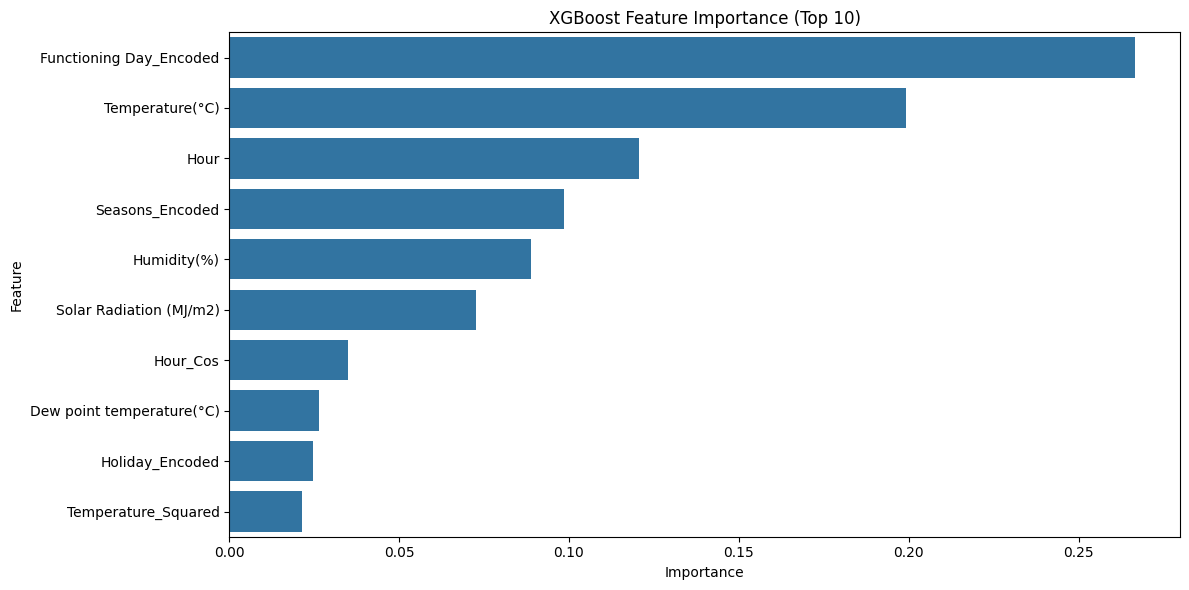

Analysis complete.
done


In [ ]:
# Feature importance for XGBoost
xgb_importance = xgb_model.feature_importances_
xgb_feature_importance = pd.DataFrame({'Feature': X_eng.columns, 'Importance': xgb_importance})
xgb_feature_importance = xgb_feature_importance.sort_values(by='Importance', ascending=False)

print("\
XGBoost Feature Importance (Top 10):")
print(xgb_feature_importance.head(10))

# Visualize XGBoost feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=xgb_feature_importance.head(10), x='Importance', y='Feature')
plt.title('XGBoost Feature Importance (Top 10)')
plt.tight_layout()
plt.show()

print("Analysis complete.")
print("done")